Experimenting with Logistic Regression
1. Experiment Divide & Conquer(voting & Stacking) with Logistic Regression
2. Experiment Plain Logistic Regression
3. Experiment Feature Subspace Sampling(voting) with Logistic Regression

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel,delayed
from scipy.stats import boxcox,mode,chi2_contingency
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report

In [2]:
forest=fetch_covtype()
x=forest["data"]
y=forest["target"]
data=pd.DataFrame(x,columns=forest.feature_names)
data["target"]=y

In [3]:
data.shape

(581012, 55)

In [4]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [5]:
data["target"].value_counts()

target
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

In [6]:
for i,j in data.isna().sum().to_dict().items():
    if j>0:
        print(i,j)

In [7]:
data.select_dtypes(["category"]).columns

Index([], dtype='object')

In [8]:
data.select_dtypes(["float"]).columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'S

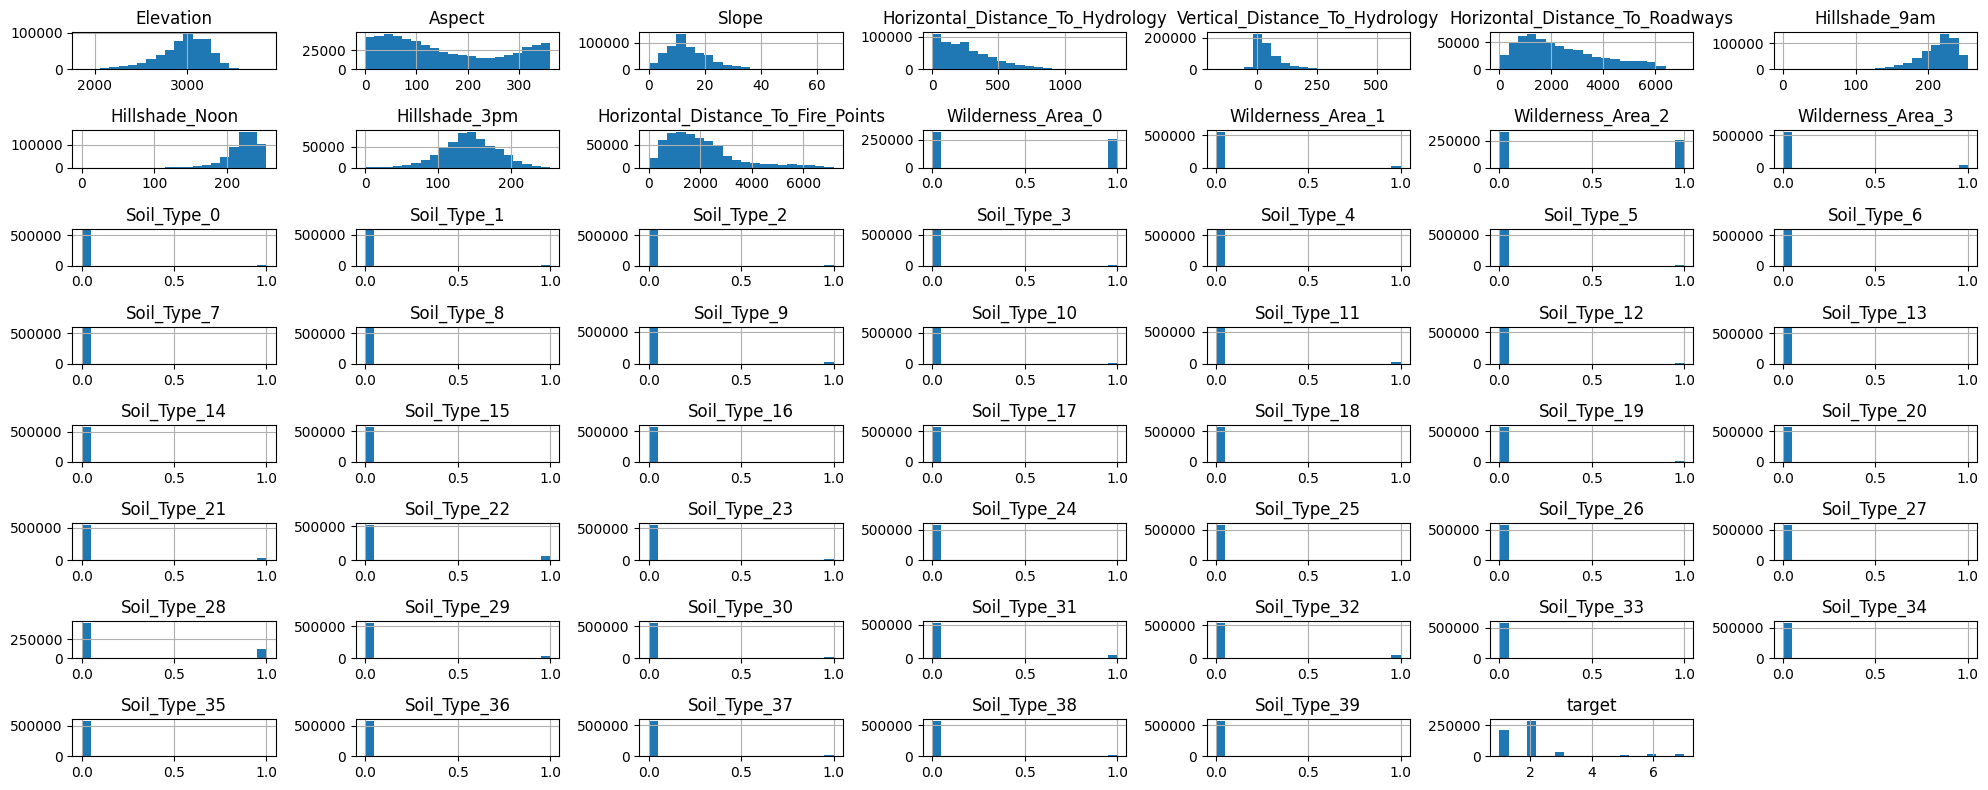

In [9]:
data.hist(figsize=(20, 8), bins=20)
plt.tight_layout()
plt.show()

In [9]:
floats_cols=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
categories_cols=['Wilderness_Area_0','Wilderness_Area_1','Wilderness_Area_2', 'Wilderness_Area_3','Soil_Type_0','Soil_Type_1','Soil_Type_2','Soil_Type_3','Soil_Type_4','Soil_Type_5','Soil_Type_6','Soil_Type_7','Soil_Type_8','Soil_Type_9','Soil_Type_10', 'Soil_Type_11','Soil_Type_12','Soil_Type_13','Soil_Type_14','Soil_Type_15','Soil_Type_16','Soil_Type_17','Soil_Type_18','Soil_Type_19','Soil_Type_20','Soil_Type_21', 'Soil_Type_22','Soil_Type_23','Soil_Type_24','Soil_Type_25','Soil_Type_26', 'Soil_Type_27','Soil_Type_28','Soil_Type_29','Soil_Type_30','Soil_Type_31','Soil_Type_32','Soil_Type_33','Soil_Type_34','Soil_Type_35','Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38','Soil_Type_39']

In [10]:
floats=data[floats_cols]
categories=data[categories_cols]

<Axes: >

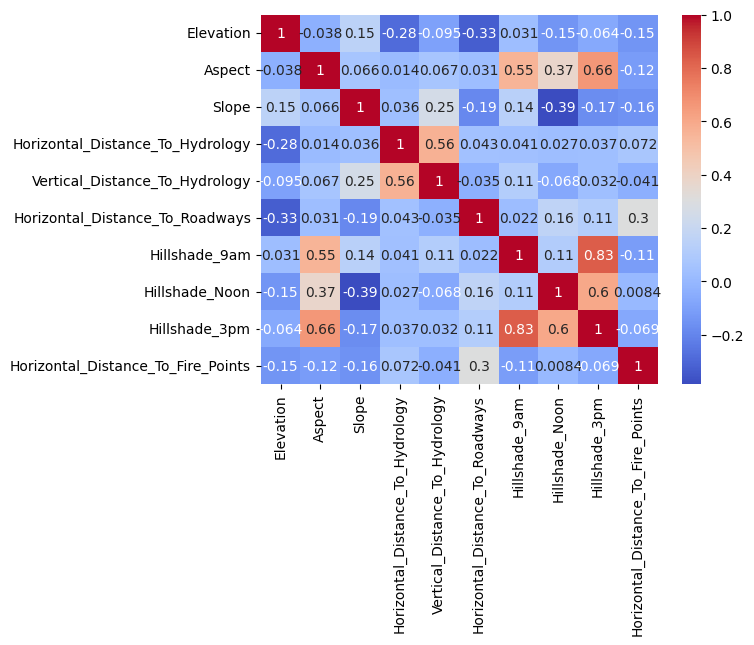

In [70]:
floats_corr=floats.corr()
sns.heatmap(floats_corr, cmap="coolwarm", annot=True)

In [11]:
mask=(floats.quantile(0.995)<floats).any(axis=1)
floats=floats[~mask]
mask=(floats.quantile(0.005)>floats).any(axis=1)
floats=floats[~mask]

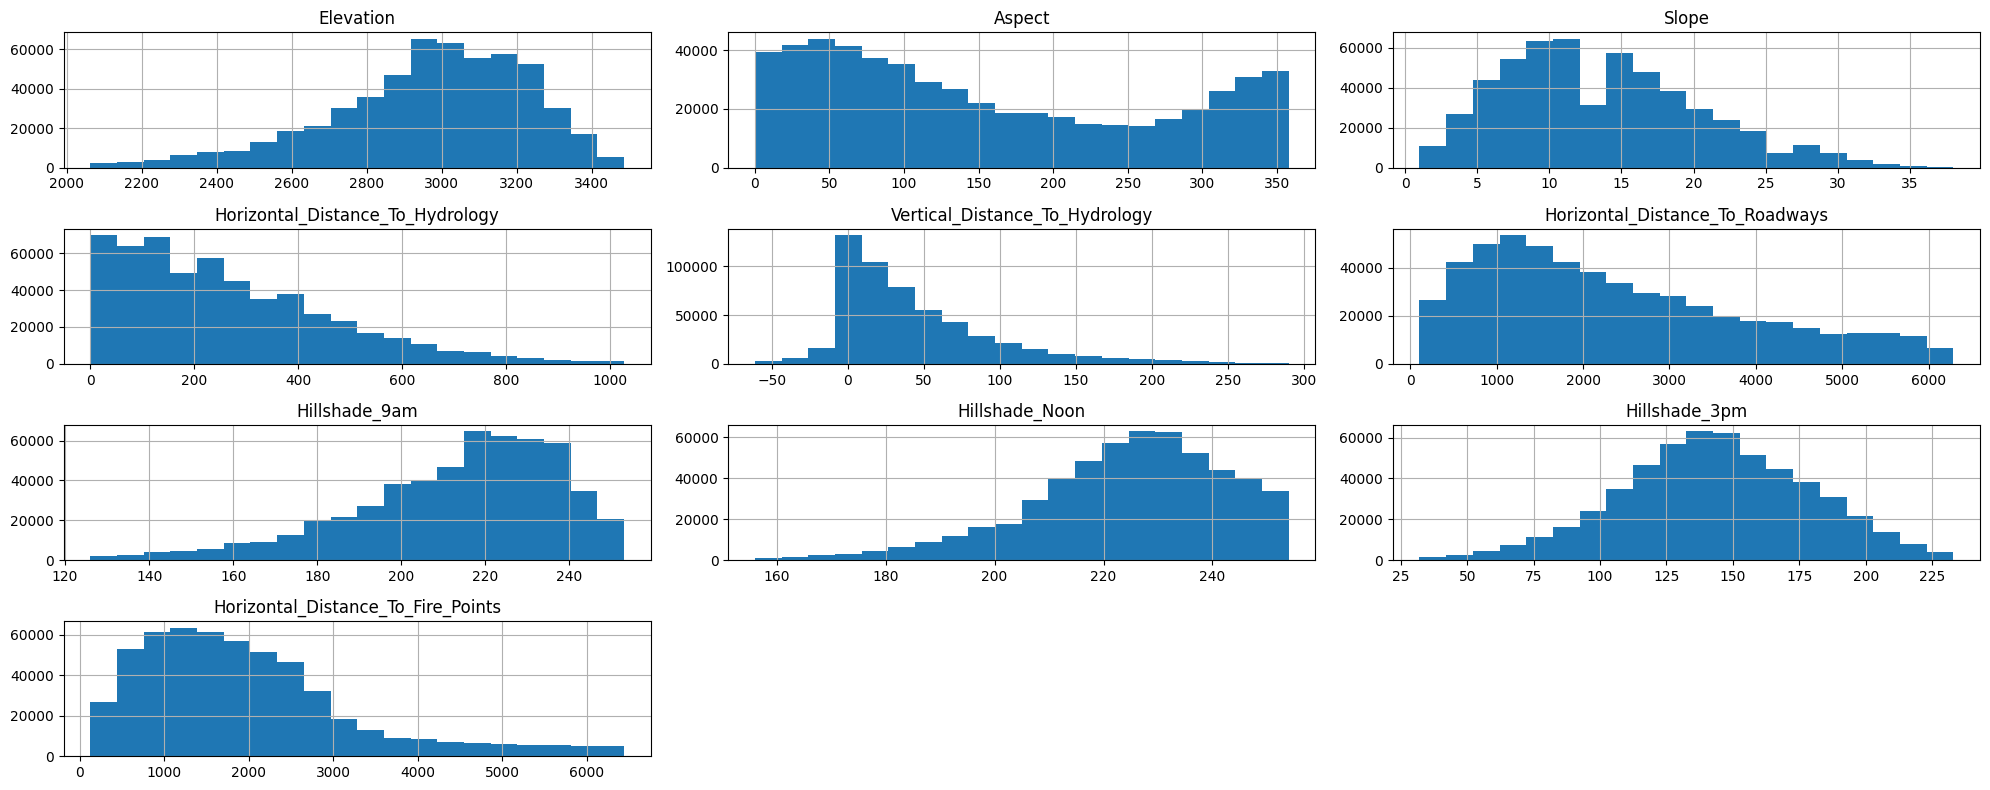

In [18]:
floats.hist(figsize=(20, 8), bins=20)
plt.tight_layout()
plt.show()

In [12]:
#instances lost %
((data.shape[0]-floats.shape[0])/data.shape[0])*100

6.549950775543362

In [13]:
data=data.loc[floats.index]

In [14]:
for i,j in data.isna().sum().to_dict().items():
    if j>0:
        print(i,j)

In [15]:
data=data.reset_index(drop=True)
data.shape

(542956, 55)

In [20]:
x=data.drop("target", axis=1)
y=data["target"]
seeds_scaled={}
for i in range(0,2,1):
    xT,xt,yT,yt=train_test_split(x,y,train_size=15000,random_state=i, stratify=y)
    scaler=MinMaxScaler()
    xT=pd.DataFrame(scaler.fit_transform(xT),columns=x.columns)
    xt=pd.DataFrame(scaler.transform(xt),columns=x.columns)
    seeds_scaled["seed"+str(i)]=[xT,xt,yT,yt]

In [28]:
floats=data[floats_cols]
categories=data[categories_cols]

1 +ve=log, sqrt, boxcox, yeo-johnson
2 -ve=power-1,2, boxcox, yeo-johnson

In [29]:
for i in floats.columns:
    j=floats[i].skew()
    print(i,"Before: ",j)
    ap=[(floats[i],"same")]
    if (floats[i] <= 0).any():
        floats[i] = floats[i] + abs(floats[i].min())+1
    if j<=-0.5:
        l=1/(floats[i]+1)
        s=np.sqrt(floats[i].max()+1-floats[i])
        b,_=boxcox(floats[i])
        b=pd.Series(data=b,name=i)
        ap=sorted([(l,"inverse"),(s,"sqrt"),(b,"box"), ap[0]], key=lambda x:abs(x[0].skew()))
    elif j>=0.5:
        l=np.log(floats[i]+1)
        s=np.sqrt(floats[i])            
        b,_=boxcox(floats[i]+1)
        b=pd.Series(data=b,name=i)
        y=PowerTransformer(method="yeo-johnson").fit_transform(np.array(floats[i]).reshape(-1,1))
        y=pd.Series(data=y.ravel(),name=i)
        ap=sorted([(l,"log"),(s,"sqrt"),(b,"box"),(y,"yeo"), ap[0]], key=lambda x:abs(x[0].skew()))
    floats[i]=ap[0][0]
    print("After: ",floats[i].skew())

Elevation Before:  -0.748403165543983
After:  0.026257286563184164
Aspect Before:  0.4141261410245466
After:  0.4141261410245466
Slope Before:  0.5494576299505938
After:  -0.03561934039791388
Horizontal_Distance_To_Hydrology Before:  0.9543226420141292
After:  -0.012738657234317326
Vertical_Distance_To_Hydrology Before:  1.494305708426714
After:  0.04279972302497725
Horizontal_Distance_To_Roadways Before:  0.6813178689528717
After:  -0.07182729990805588
Hillshade_9am Before:  -0.8916011244993
After:  0.1130961894354154
Hillshade_Noon Before:  -0.7197510467523685
After:  -0.0675219162611795
Hillshade_3pm Before:  -0.12649274675813837
After:  -0.12649274675813837
Horizontal_Distance_To_Fire_Points Before:  1.2329865242436262
After:  -0.012484599197172331


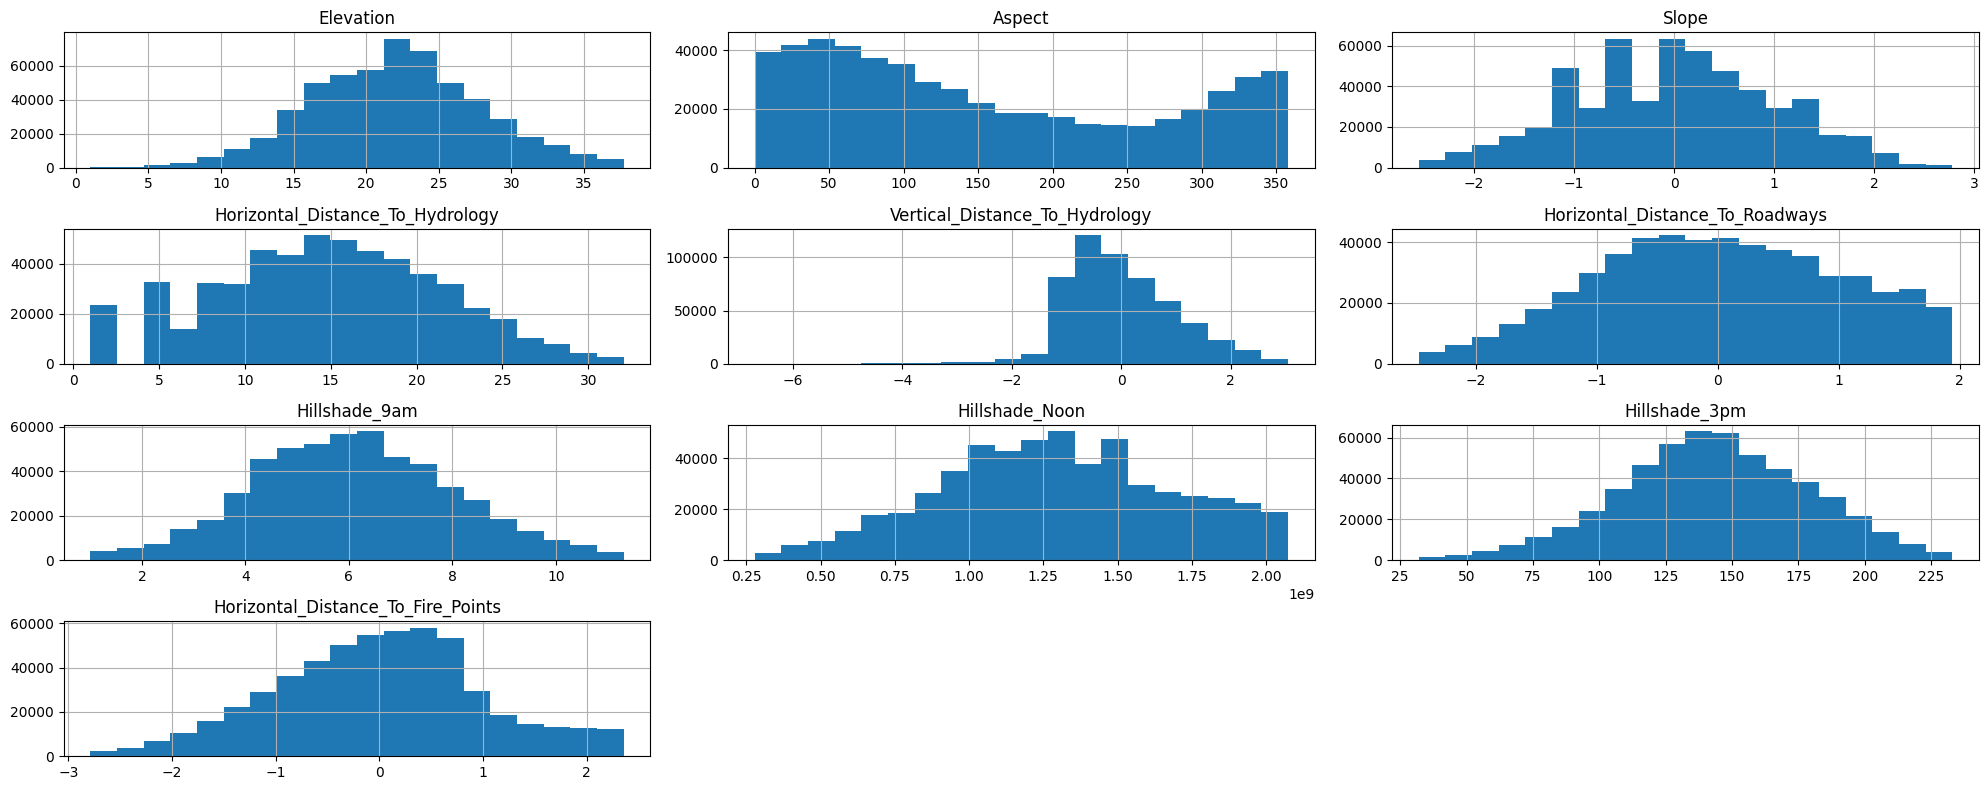

In [31]:
floats.hist(figsize=(20, 8), bins=20)
plt.tight_layout()
plt.show()

In [30]:
data_transformed=pd.concat([floats,categories,data["target"]], axis=1)

In [31]:
x=data_transformed.drop("target", axis=1)
y=data_transformed["target"]
seeds_transformed_voting={}
for i in range(0,2,1):
    xT,xt,yT,yt=train_test_split(x,y,train_size=15000,random_state=i,stratify=y)
    scaler=MinMaxScaler()
    xT=pd.DataFrame(scaler.fit_transform(xT),columns=x.columns)
    xt=pd.DataFrame(scaler.transform(xt),columns=x.columns)
    seeds_transformed_voting["seed"+str(i)]=[xT,xt,yT,yt]

Divide & Conquer Voting Model

Using Transformed data

In [32]:
p1=['Elevation','Aspect','Slope']
p2=['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology']
p3=['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']
p4=['Wilderness_Area_0','Wilderness_Area_1','Wilderness_Area_2','Wilderness_Area_3']
p5=['Horizontal_Distance_To_Fire_Points']
p6=['Horizontal_Distance_To_Roadways']
p7=['Soil_Type_0','Soil_Type_1','Soil_Type_2','Soil_Type_3','Soil_Type_4','Soil_Type_5', 'Soil_Type_6','Soil_Type_7','Soil_Type_8','Soil_Type_9','Soil_Type_10','Soil_Type_11','Soil_Type_12','Soil_Type_13','Soil_Type_14','Soil_Type_15','Soil_Type_16', 'Soil_Type_17','Soil_Type_18','Soil_Type_19','Soil_Type_20','Soil_Type_21', 'Soil_Type_22','Soil_Type_23','Soil_Type_24','Soil_Type_25','Soil_Type_26', 'Soil_Type_27','Soil_Type_28','Soil_Type_29','Soil_Type_30','Soil_Type_31','Soil_Type_32','Soil_Type_33','Soil_Type_34','Soil_Type_35','Soil_Type_36','Soil_Type_37', 'Soil_Type_38','Soil_Type_39']

In [32]:
def hard_soft_voting(seed_no:int,seed:list)->tuple:
    voters_hard=[]
    voters_soft=[]
    models=[]
    for k in [p1,p2,p3,p4,p5,p6,p7]:
        model=LogisticRegressionCV(solver="saga",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
        model.fit(seed[0][k],seed[2])
        preds=model.predict(seed[1][k])
        voters_hard.append(preds)
        probs=model.predict_proba(seed[1][k])
        voters_soft.append(probs)
        models.append(model)
    stacked_preds=np.vstack(voters_hard).T
    voting_hard=mode(stacked_preds, axis=1).mode
    voting_soft=np.array(voters_soft) 
    voting_soft=np.argmax(np.mean(voters_soft, axis=0), axis=1)
    soft_score=f1_score(seed[3],voting_hard,average="weighted")
    hard_score=f1_score(seed[3],voting_soft,average="weighted")
    return (seed_no,soft_score,hard_score,models)

In [33]:
results_voting=Parallel(n_jobs=-1)(delayed(hard_soft_voting)(seed_no,seed) for seed_no,seed in seeds_transformed_voting.items())

[('seed0',
  0.46518637985578204,
  0.04693091030051435,
  [LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', solver='saga'),
   LogisticRegressionCV(class_weight='balanced', n_jobs=-1, penalty='l1',
                        scoring='f1_weighted', 

Divide & Conquer Stacked Model

In [33]:
seeds_transformed_stacking={}
for i in range(0,2,1):
    xT,xt,yT,yt=train_test_split(x,y,train_size=30000,random_state=i,stratify=y)
    xxT,xxt,yyT,yyt=train_test_split(xT,yT,train_size=15000,random_state=i,stratify=yT)
    scaler=MinMaxScaler()
    xxT=pd.DataFrame(scaler.fit_transform(xxT),columns=x.columns)
    xxt=pd.DataFrame(scaler.transform(xxt),columns=x.columns)
    xt=pd.DataFrame(scaler.transform(xt),columns=x.columns)    
    seeds_transformed_stacking["seed"+str(i)]=[xxT,xxt,yyT,yyt,xt,yt]

In [34]:
def training_submodels(seed:list)->tuple:
    models=[]
    for k in [p1,p2,p3,p4,p5,p6,p7]:
        model=LogisticRegressionCV(solver="saga",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
        model.fit(seed[0][k],seed[2])
        models.append(model)    
    return models

In [35]:
results_s1=Parallel(n_jobs=-1)(delayed(training_submodels)(seed) for seed in seeds_transformed_stacking.values())

In [36]:
def stacking_model(models:list, seed:list)->list:
    features=[]
    for model,subset in zip(models, [p1,p2,p3,p4,p5,p6,p7]):
        features.append(model.predict_proba(seed[1][subset]))
    model=LogisticRegressionCV(solver="saga",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
    features=np.hstack(features)
    model.fit(features,seed[3])
    return model

In [37]:
result_stacked=Parallel(n_jobs=-1)(delayed(stacking_model)(results,seed) for results,seed in zip(results_s1,seeds_transformed_stacking.values()))

In [38]:
stacked_scores=[]
for result,model,seed in zip(results_s1,result_stacked,seeds_transformed_stacking.values()): 
    features=[]
    for smodel,subset in zip(result,[p1,p2,p3,p4,p5,p6,p7]):
        features.append(smodel.predict_proba(seed[4][subset]))
    features=np.hstack(features)
    pred=model.predict(features)
    stacked_scores.append((f1_score(seed[5],pred, average="weighted")))

In [39]:
stacked_scores

[0.5853693627622976, 0.5928141266462439]

Logistic Regression

In [48]:
a,b,c,d=train_test_split(x,y,train_size=15000,random_state=1,stratify=y)
model=LogisticRegressionCV(solver="saga",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
perm_importance=permutation_importance(estimator=model, X=b, y=d, n_jobs=-1, n_repeats=5, random_state=i)
imps=abs(perm_importance.importances_mean)
imps

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [49]:
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.32599982733468447

In [50]:
a,b,c,d=train_test_split(x,y,train_size=15000,random_state=1,stratify=y)
model=LogisticRegressionCV(solver="sag",penalty="l2",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
perm_importance=permutation_importance(estimator=model, X=b, y=d, n_jobs=-1, n_repeats=5, random_state=i)
imps=abs(perm_importance.importances_mean)
imps

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [51]:
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.32599982733468447

In [60]:
a,b,c,d=train_test_split(x,y,train_size=15000,random_state=1,stratify=y)
model=LogisticRegressionCV(solver="liblinear",penalty="l2",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.6115611630072731

Using Only Standardized Data

In [52]:
a,b,c,d=seeds_scaled["seed1"]
model=LogisticRegressionCV(solver="sag",penalty="l2",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
perm_importance=permutation_importance(estimator=model, X=b, y=d, n_jobs=-1, n_repeats=5, random_state=i)
imps=abs(perm_importance.importances_mean)
imps

array([1.06596060e-01, 3.12087938e-03, 1.86823577e-03, 4.22755720e-03,
       2.09046137e-03, 3.66024380e-03, 1.16334641e-03, 1.51029314e-02,
       7.83253798e-04, 1.65010538e-03, 3.76424952e-03, 1.74093654e-03,
       2.08410760e-02, 6.94013896e-03, 4.94609513e-04, 6.26217366e-03,
       2.57283959e-04, 6.87345766e-03, 6.14088010e-05, 6.00300275e-04,
       1.09949300e-06, 2.93553343e-07, 2.90235640e-05, 4.58252088e-03,
       2.30460010e-04, 1.37251331e-03, 1.66157974e-03, 1.34204732e-04,
       0.00000000e+00, 1.09003339e-04, 8.28886052e-04, 1.29718679e-03,
       4.24638702e-05, 2.60662264e-04, 6.87893846e-04, 1.37220950e-02,
       1.17279137e-02, 3.01829393e-03, 1.62013261e-05, 1.25600910e-03,
       7.10354137e-05, 2.80805178e-05, 1.01702162e-02, 1.15247444e-03,
       4.98121041e-03, 1.20162808e-02, 1.54515817e-02, 8.59170863e-04,
       1.07154049e-04, 6.72301829e-07, 3.58572167e-04, 3.53545084e-03,
       7.40560645e-04, 4.86516835e-04])

In [53]:
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.6149434170488801

In [54]:
a,b,c,d=seeds_scaled["seed1"]
model=LogisticRegressionCV(solver="saga",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
perm_importance=permutation_importance(estimator=model, X=b, y=d, n_jobs=-1, n_repeats=5, random_state=i)
imps=abs(perm_importance.importances_mean)
imps

array([1.69216629e-01, 1.02819484e-03, 1.72603779e-03, 1.30449790e-02,
       2.54861570e-03, 1.21967256e-02, 1.40031353e-02, 4.30326771e-02,
       3.56343953e-02, 6.15415868e-03, 3.02139726e-02, 2.78254394e-03,
       8.79902484e-03, 5.61448358e-03, 4.80106445e-04, 3.36736572e-03,
       1.85363154e-04, 1.31741424e-02, 2.42794744e-04, 9.28339021e-04,
       4.95052804e-06, 2.04744489e-04, 1.27581794e-03, 4.56162357e-03,
       1.54587755e-03, 5.69455380e-03, 1.91935539e-03, 6.34326480e-05,
       0.00000000e+00, 2.04274831e-04, 1.45746917e-03, 9.69679365e-06,
       7.52746931e-04, 2.76729403e-04, 2.58549420e-04, 4.90338795e-03,
       2.63832046e-03, 4.90727224e-03, 4.56559641e-05, 6.68236653e-04,
       6.79146724e-05, 5.32110368e-04, 1.54912855e-02, 5.40483529e-04,
       6.05852691e-03, 6.38211461e-03, 2.10332750e-03, 1.32076944e-03,
       4.70039391e-04, 4.00320513e-05, 2.01739780e-04, 4.41399819e-03,
       3.68033392e-03, 1.21135117e-03])

In [55]:
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.5027663916746474

In [61]:
a,b,c,d=train_test_split(x,y,train_size=15000,random_state=1,stratify=y)
model=LogisticRegressionCV(solver="liblinear",penalty="l2",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
model.fit(a,c)
pred=model.predict(b)
f1_score(d,pred,average="weighted")

0.6115611630072731

In [56]:
x=data.drop("target", axis=1)
y=data["target"]
seeds_scaled_stacking={}
for i in range(0,10,1):
    xT,xt,yT,yt=train_test_split(x,y,train_size=30000,random_state=i,stratify=y)
    xxT,xxt,yyT,yyt=train_test_split(xT,yT,train_size=15000,random_state=i,stratify=yT)
    scaler=MinMaxScaler()
    xxT=pd.DataFrame(scaler.fit_transform(xxT),columns=x.columns)
    xxt=pd.DataFrame(scaler.transform(xxt),columns=x.columns)
    xt=pd.DataFrame(scaler.transform(xt),columns=x.columns)    
    seeds_scaled_stacking["seed"+str(i)]=[xxT,xxt,yyT,yyt,xt,yt]

In [57]:
results_s1=Parallel(n_jobs=-1)(delayed(training_submodels)(seed) for seed in seeds_scaled_stacking.values())
result_stacked=Parallel(n_jobs=-1)(delayed(stacking_model)(results,seed) for results,seed in zip(results_s1,seeds_scaled_stacking.values()))

In [58]:
stacked_scores=[]
for result,model,seed in zip(results_s1,result_stacked,seeds_scaled_stacking.values()): 
    features=[]
    for smodel,subset in zip(result,[p1,p2,p3,p4,p5,p6,p7]):
        features.append(smodel.predict_proba(seed[4][subset]))
    features=np.hstack(features)
    pred=model.predict(features)
    print((f1_score(seed[5],pred, average="weighted")))

0.5487884861927702
0.5959894358657756
0.5352863477765901
0.5277157443914644
0.5056780097377044
0.5456175652654224
0.5277176697228128
0.5772612345273017
0.46841859867364344
0.5190281168734374


Using Liblinear

In [62]:
def hard_soft_voting(seed_no:int,seed:list)->tuple:
    voters_hard=[]
    voters_soft=[]
    models=[]
    for k in [p1,p2,p3,p4,p5,p6,p7]:
        model=LogisticRegressionCV(solver="liblinear",penalty="l1",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
        model.fit(seed[0][k],seed[2])
        preds=model.predict(seed[1][k])
        voters_hard.append(preds)
        probs=model.predict_proba(seed[1][k])
        voters_soft.append(probs)
        models.append(model)
    stacked_preds=np.vstack(voters_hard).T
    voting_hard=mode(stacked_preds, axis=1).mode
    voting_soft=np.array(voters_soft) 
    voting_soft=np.argmax(np.mean(voters_soft, axis=0), axis=1)
    soft_score=f1_score(seed[3],voting_hard,average="weighted")
    hard_score=f1_score(seed[3],voting_soft,average="weighted")
    return (seed_no,soft_score,hard_score,models)

In [ ]:
results_voting=Parallel(n_jobs=-1)(delayed(hard_soft_voting)(seed_no,seed) for seed_no,seed in seeds_scaled.items())

In [ ]:
for i in results_voting:
    print(i[1],i[2])

0.2324439062606291 0.009311051096032204
0.3568541727836332 0.009212904699052062


Correlations Based Features 

In [65]:
model=LogisticRegressionCV(solver="saga",penalty="elasticnet",scoring="f1_weighted",class_weight="balanced",n_jobs=-1,l1_ratios=[0.5,0.5])
model.fit(a,c)
f1_score(model.predict(b),d, average="weighted")

0.41115720377935566

Feature Subspace (Voting)

In [23]:
voters_hard=[]
voters_soft=[]
models=[]
for i in range(0,5,1):
    feature_subsample=random.sample(x.columns.to_list(), random.randint(5,7))
    xs=data[feature_subsample]
    xT,xt,yT,yt=train_test_split(xs,y,train_size=15000, random_state=i,stratify=y)
    scaler=MinMaxScaler()
    xT=pd.DataFrame(scaler.fit_transform(xT),columns=xs.columns)
    xt=pd.DataFrame(scaler.transform(xt),columns=xs.columns)    
    model=LogisticRegressionCV(solver="liblinear",penalty="l2",scoring="f1_weighted",class_weight="balanced",n_jobs=-1)
    model.fit(xT,yT)
    voters_hard.append(model.predict(xt))
    voters_soft.append(model.predict_proba(xt))
stacked_preds=np.vstack(voters_hard).T
voting_hard=mode(stacked_preds, axis=1).mode
voting_soft=np.array(voters_soft) 
voting_soft=np.argmax(np.mean(voters_soft, axis=0), axis=1)

In [24]:
soft_score=f1_score(yt,voting_hard,average="weighted")
hard_score=f1_score(yt,voting_soft,average="weighted")  

In [25]:
soft_score,hard_score

(0.10161923111386947, 0.007687993243667754)

In [26]:
a,b,c,d=train_test_split(x,y,train_size=20000,stratify=y,random_state=1)
mscaler=MinMaxScaler()
a=mscaler.fit_transform(a)
b=mscaler.transform(b)
model=LogisticRegressionCV(solver="liblinear",penalty="l2",scoring="f1_weighted",n_jobs=-1,cv=10,class_weight="balanced")
model.fit(a,c)
pred=model.predict(b)
f1=f1_score(d,pred,average="weighted")
print(f1,classification_report(d,pred))

0.622141739315817               precision    recall  f1-score   support

           1       0.66      0.68      0.67    194460
           2       0.79      0.53      0.63    258014
           3       0.56      0.55      0.55     28121
           4       0.21      0.79      0.34      2150
           5       0.08      0.52      0.14      8469
           6       0.29      0.55      0.38     14682
           7       0.40      0.79      0.53     17060

    accuracy                           0.60    522956
   macro avg       0.43      0.63      0.46    522956
weighted avg       0.69      0.60      0.62    522956



In [41]:
xk=x

In [42]:
xk["Elevation_Diff_Hydro"] = xk["Elevation"] - xk["Horizontal_Distance_To_Hydrology"]
xk["Elevation_Diff_Road"] = xk["Elevation"] - xk["Horizontal_Distance_To_Roadways"]
xk["Elevation_Diff_Fire"] = xk["Elevation"] - xk["Horizontal_Distance_To_Fire_Points"]
xk["Elevation_Slope_Ratio"] = xk["Slope"] / (xk["Elevation"] + 1)
xk["Hydro_Road_Ratio"] = xk["Horizontal_Distance_To_Hydrology"] / (xk["Horizontal_Distance_To_Roadways"] + 1)
xk["Fire_Road_Ratio"] = xk["Horizontal_Distance_To_Fire_Points"] / (xk["Horizontal_Distance_To_Roadways"] + 1)
xk["Fire_Road_Diff"] = xk["Horizontal_Distance_To_Fire_Points"] - xk["Horizontal_Distance_To_Roadways"]
xk["Near_Road"] = (xk["Horizontal_Distance_To_Roadways"] < 1000).astype(int)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
xk_poly = poly.fit_transform(xk[["Elevation", "Slope", "Horizontal_Distance_To_Hydrology", "Hillshade_Noon"]])
poly_features = [f"Poly_{i}" for i in range(xk_poly.shape[1])]
xk_poly_df = pd.DataFrame(xk_poly, columns=poly_features)
xk = pd.concat([xk, xk_poly_df], axis=1)

In [43]:
a,b,c,d=train_test_split(xk,y,train_size=20000,stratify=y,random_state=1)
mscaler=MinMaxScaler()
a=mscaler.fit_transform(a)
b=mscaler.transform(b)
model=LogisticRegressionCV(solver="liblinear",penalty="l2",scoring="f1_weighted",n_jobs=-1,cv=10,class_weight="balanced")
model.fit(a,c)
pred=model.predict(b)
f1=f1_score(d,pred,average="weighted")
print(f1,classification_report(d,pred))

0.6318209639361343               precision    recall  f1-score   support

           1       0.66      0.66      0.66    194460
           2       0.79      0.55      0.65    258014
           3       0.61      0.65      0.63     28121
           4       0.40      0.81      0.53      2150
           5       0.09      0.54      0.15      8469
           6       0.29      0.51      0.37     14682
           7       0.40      0.81      0.54     17060

    accuracy                           0.61    522956
   macro avg       0.46      0.65      0.50    522956
weighted avg       0.69      0.61      0.63    522956



In [45]:
# best score 0.6318209639361343

Final yay! stacking with voting on transformed data performed similar to plain logistic regression